In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from codecarbon import EmissionsTracker
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"CUDA is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    
    torch.cuda.empty_cache()
    
    torch.cuda.set_per_process_memory_fraction(0.5)
else:
    print("CUDA is not available. Using CPU.")

device

Using device: cuda
CUDA is available!
GPU Name: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.6 GB
Number of GPUs: 1
Current GPU: 0


device(type='cuda')

In [3]:
arquivos = ['Interpolado_Marambaia.csv', 'Interpolado_VilaMilitar.csv', 'Interpolado_jacarepagua.csv']
dfs = [pd.read_csv(a, sep=',', encoding='utf8') for a in arquivos]
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(['datetime'], ignore_index=True)
df

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",datetime
0,0.0,1021.400000,1021.400000,1021.100000,0.0,18.200000,15.700000,18.200000,18.0,15.800000,15.40,86.000000,85.0,86.0,28.0,3.8,2.000000,2002-11-08 00:00:00
1,0.0,1021.900000,1022.000000,1021.400000,0.0,18.500000,16.200000,18.600000,18.2,16.300000,15.70,87.000000,85.0,87.0,348.0,5.9,2.500000,2002-11-08 01:00:00
2,3.6,1021.700000,1022.500000,1021.700000,0.0,17.800000,15.900000,18.500000,17.6,16.400000,15.40,89.000000,86.0,89.0,17.0,6.1,2.500000,2002-11-08 02:00:00
3,0.0,1020.900000,1021.700000,1020.900000,0.0,17.400000,15.700000,17.800000,17.4,15.900000,15.70,90.000000,89.0,90.0,29.0,3.0,1.800000,2002-11-08 03:00:00
4,0.0,1020.300000,1020.800000,1020.300000,0.0,17.200000,15.600000,17.400000,17.2,15.800000,15.60,91.000000,90.0,91.0,2.0,3.9,2.400000,2002-11-08 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414824,0.0,1017.800000,1017.800000,1017.400000,3.7,20.700000,17.900000,20.800000,20.1,17.900000,17.50,85.000000,82.0,84.0,256.0,3.5,0.800000,2025-05-31 21:00:00
414825,0.0,1018.200000,1018.200000,1017.700000,0.0,21.400000,17.900000,21.400000,20.7,18.000000,17.90,84.000000,80.0,81.0,237.0,6.2,1.600000,2025-05-31 22:00:00
414826,0.0,1019.088889,1019.088889,1018.533333,0.0,20.009091,18.066667,21.009091,20.2,18.585714,17.35,85.857143,78.0,86.0,47.0,7.6,2.376190,2025-05-31 22:00:00
414827,0.0,1019.733333,1019.733333,1019.000000,0.0,19.254545,18.300000,20.754545,19.7,18.614286,16.80,86.142857,70.0,89.0,81.0,10.6,6.257143,2025-05-31 23:00:00


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

input_data = df.drop([
    'datetime',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)'], axis=1)
targets = df['UMIDADE RELATIVA DO AR, HORARIA (%)'].values
T = 20                   
D = input_data.shape[1] 
N = len(input_data) - T

In [5]:
train_size = int(len(input_data) * 0.80)

scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [6]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    device = X.device
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    out = self.fc(out[:, -1, :])
    return out

In [7]:
model = LSTM(input_dim=D, hidden_dim=256, layer_dim=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
def train(model, learning_rate, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] — Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

In [13]:
def plot_dispersion(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()
            predictions.append(batch_pred)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true_np, y_pred_np, alpha=0.7, color='blue')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Dispersion Plot: True vs Predicted')
    plt.grid(True)
    plt.plot([y_true_np.min(), y_true_np.max()], [y_true_np.min(), y_true_np.max()], 'r--')
    plt.tight_layout()
    plt.show()

In [9]:
def return_rmse(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()
            predictions.append(batch_pred)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    return rmse

In [10]:
tracker = EmissionsTracker(
    project_name="UMIDADE lstm",
    output_file='codecarbon_emission_lstm.csv',
    log_level = "critical"
)

tracker.start()

train_losses, test_losses = train(
    model,
    learning_rate=0.01,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=25,
    batch_size=64
)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 13:50:11] Multiple instances of codecarbon are allowed to run at the same time.


Epoch [1/25] — Train Loss: 330.3338, Test Loss: 340.3768


Epoch [2/25] — Train Loss: 127.4137, Test Loss: 318.9756


Epoch [3/25] — Train Loss: 92.8996, Test Loss: 313.2622


Epoch [4/25] — Train Loss: 101.1197, Test Loss: 342.9193


Epoch [5/25] — Train Loss: 124.4140, Test Loss: 340.6295


Epoch [6/25] — Train Loss: 132.2926, Test Loss: 343.1400


Epoch [7/25] — Train Loss: 128.5415, Test Loss: 337.7273


Epoch [8/25] — Train Loss: 123.1631, Test Loss: 335.4157


Epoch [9/25] — Train Loss: 121.9254, Test Loss: 335.9721


Epoch [10/25] — Train Loss: 125.1595, Test Loss: 336.8816


Epoch [11/25] — Train Loss: 120.3230, Test Loss: 335.4553


Epoch [12/25] — Train Loss: 120.8481, Test Loss: 340.7006


Epoch [13/25] — Train Loss: 121.8182, Test Loss: 336.0378


Epoch [14/25] — Train Loss: 126.1076, Test Loss: 339.7549


Epoch [15/25] — Train Loss: 123.2677, Test Loss: 331.9211


Epoch [16/25] — Train Loss: 124.8973, Test Loss: 335.4547


Epoch [17/25] — Train Loss: 126.2494, Test Loss: 331.9170


Epoch [18/25] — Train Loss: 127.9603, Test Loss: 324.9290


Epoch [19/25] — Train Loss: 124.3106, Test Loss: 330.2236


Epoch [20/25] — Train Loss: 126.9938, Test Loss: 329.6454


Epoch [21/25] — Train Loss: 125.5525, Test Loss: 330.7920


Epoch [22/25] — Train Loss: 126.1772, Test Loss: 332.7439


Epoch [23/25] — Train Loss: 129.0999, Test Loss: 337.6846


Epoch [24/25] — Train Loss: 130.4313, Test Loss: 333.0558


Epoch [25/25] — Train Loss: 127.7632, Test Loss: 336.4585
emissions=0.0013999612434365363


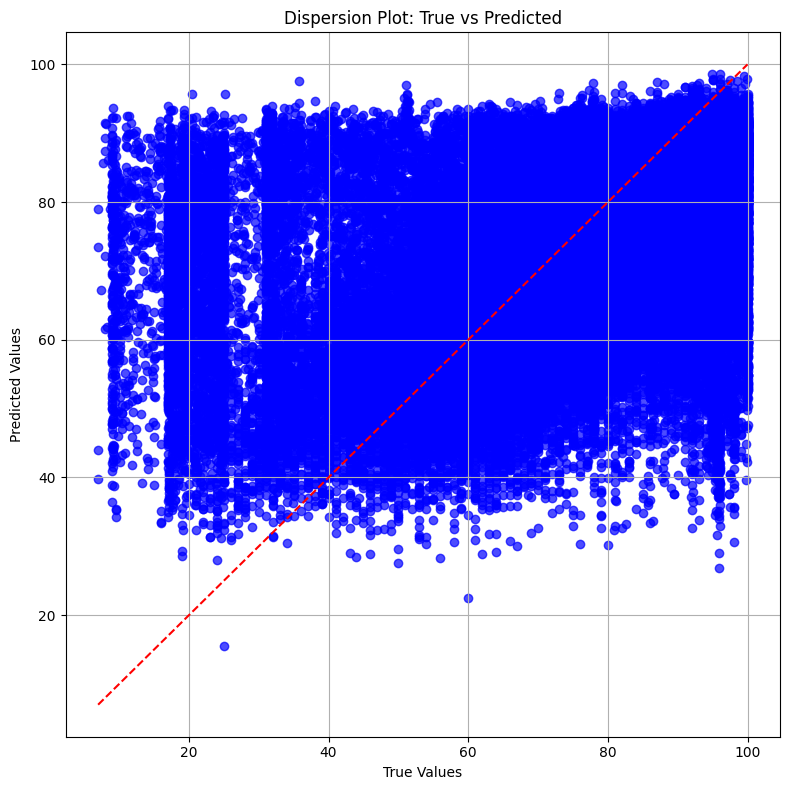

In [14]:
plot_dispersion(model, X_test, y_test)


In [15]:
def print_rmse(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()
            predictions.append(batch_pred)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    print(f"RMSE: {rmse:.4f}")

In [16]:
print_rmse(model, X_test, y_test)


RMSE: 18.3428
